In [1]:
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from sklearn.externals import joblib
from my_measures import BinaryClassificationPerformance
%matplotlib inline

### Read Original Data

In [2]:
amazon = pd.read_csv('/Users/xyche/Documents/Parsons_Grad/ML_Practice/AmazonReview/Amazon.csv')
print(amazon.shape)

(455000, 13)


#### Spliting into random sets

In [5]:
from sklearn.model_selection import train_test_split

raw_data_train, raw_data_test, y_labeled, y_labeled = train_test_split(amazon, amazon['helpful'], test_size= 0.2, random_state=27)

In [6]:
raw_data_train.to_csv('/Users/xyche/Documents/Parsons_Grad/ML_Practice/AmazonReview/raw_data_train.csv', index=False)
raw_data_test.to_csv('/Users/xyche/Documents/Parsons_Grad/ML_Practice/AmazonReview/raw_data_test.csv', index=False)
y_labeled.to_csv('/Users/xyche/Documents/Parsons_Grad/ML_Practice/AmazonReview/y_labeled.csv')
y_labeled.to_csv('/Users/xyche/Documents/Parsons_Grad/ML_Practice/AmazonReview/y_labeled.csv')

#### Teat Training Data

In [7]:
amazonTrain = pd.read_csv('/Users/xyche/Documents/Parsons_Grad/ML_Practice/AmazonReview/raw_data_train.csv')
print(amazonTrain.shape)
type(amazonTrain.Text)

(364000, 13)


pandas.core.series.Series

In [8]:
s = pd.Series([amazon])
raw = s.to_string()
type(raw)

str

#### Taking Summaries and Comments from the documents as key features to do word analysis
#### Taking out stopwords, case differences, and punctuation
#### using hash vectorizer and tfidf tranformation to convert words into matrix

In [9]:
from sklearn.feature_extraction.text import HashingVectorizer
hv = HashingVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', token_pattern='(?u)\b\w\w+\b', n_features= 2*17, analyzer='word', norm='l1', non_negative=False)
X_hv = hv.fit_transform(amazonTrain.Text)
print(X_hv.shape)

(364000, 34)


In [10]:
joblib.dump(hv, 'hv.pkl')

['hv.pkl']

In [11]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(norm='l1', sublinear_tf=True)
X_tfidf = transformer.fit_transform(X_hv)

joblib.dump(transformer, 'transformer.pkl') # pickle

['transformer.pkl']

In [12]:
from sklearn.feature_extraction.text import HashingVectorizer
corpusSum = amazonTrain.Summary.values.astype('U')
sums = HashingVectorizer(strip_accents='unicode', lowercase=True, stop_words='english', token_pattern='(?u)\b\w\w+\b', n_features= 2*17, analyzer='word', norm=None, non_negative=False)
X_sums = sums.fit_transform(corpusSum)
print(X_sums.shape)

(364000, 34)


In [13]:
joblib.dump(sums, 'hvsum.pkl')

['hvsum.pkl']

In [14]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(norm='l1', sublinear_tf=True)
X_tfidf_sum = transformer.fit_transform(X_sums)

joblib.dump(transformer, 'transformer_sum.pkl') # pickle

['transformer_sum.pkl']

#### Also considering the length of each summary and comment to eveluate the helpfulness

In [16]:
amazonTrain['reviewLen'] = amazonTrain['Text'].str.len()
amazonTrain['sumLen'] = amazonTrain['Summary'].str.len().replace(np.nan,0)


X_length_features = amazonTrain[["reviewLen","sumLen"]]

#### Combining feature matrix

In [18]:
#Combine words matrix
from scipy.sparse import csr_matrix, hstack
X_combined = hstack([X_tfidf,X_tfidf_sum])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(364000, 68)


In [19]:
from scipy.sparse import csr_matrix, hstack
X_length_features_csr = csr_matrix(X_length_features)
X_combined = hstack([X_matrix, X_length_features_csr])
X_feature = csr_matrix(X_combined) 
print(X_feature.shape)

(364000, 70)


In [20]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler(with_mean=False)
X = sc.fit_transform(X_feature)
print(X.shape)

joblib.dump(sc, 'sc.pkl')

(364000, 70)


['sc.pkl']

In [21]:
y = amazonTrain['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### Testing different modules on the training set

In [22]:
from my_measures import BinaryClassificationPerformance

#### nbs

In [23]:
from sklearn.naive_bayes import MultinomialNB
nbs = MultinomialNB()
nbs.fit(X, y)
joblib.dump(nbs, 'nbs.pkl') # pickle

nbs_performance = BinaryClassificationPerformance(nbs.predict(X), y, 'nbs')
nbs_performance.compute_measures()
print(nbs_performance.performance_measures)

{'Pos': 26581, 'Neg': 337419, 'TP': 30, 'TN': 337360, 'FP': 59, 'FN': 26551, 'Accuracy': 0.9268956043956044, 'Precision': 0.33707865168539325, 'Recall': 0.001128625710093676, 'desc': 'nbs'}


#### ols

In [24]:
from sklearn import linear_model
ols = linear_model.SGDClassifier(loss="squared_loss")
ols.fit(X, y)
joblib.dump(ols, 'ols.pkl') # pickle

ols_performance = BinaryClassificationPerformance(ols.predict(X), y, 'ols')
ols_performance.compute_measures()
print(ols_performance.performance_measures)

C:\Users\xyche\Anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


{'Pos': 26581, 'Neg': 337419, 'TP': 41, 'TN': 337343, 'FP': 76, 'FN': 26540, 'Accuracy': 0.9268791208791208, 'Precision': 0.3504273504273504, 'Recall': 0.0015424551371280239, 'desc': 'ols'}


#### randomForest

In [25]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier(n_estimators=100, criterion='gini', max_depth=7, min_samples_split=9, min_samples_leaf=1, min_weight_fraction_leaf=0.5, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.1, min_impurity_split=None, bootstrap=True, oob_score=False, n_jobs=None, random_state=27, verbose=0, warm_start=False, class_weight=None)
rf.fit(X, y)
joblib.dump(rf, 'rf.pkl') # pickle

rf_performance = BinaryClassificationPerformance(rf.predict(X), y, 'rf')
rf_performance.compute_measures()
print(rf_performance.performance_measures)

{'Pos': 26581, 'Neg': 337419, 'TP': 0, 'TN': 337419, 'FP': 0, 'FN': 26581, 'Accuracy': 0.9269752747252747, 'Precision': nan, 'Recall': 0.0, 'desc': 'rf'}


C:\Users\xyche\Documents\Parsons_Grad\ML_Practice\AmazonReview\my_measures.py:25: RuntimeWarning: invalid value encountered in longlong_scalars
  self.performance_measures['Precision'] = self.performance_measures['TP'] / (self.performance_measures['TP'] + self.performance_measures['FP'])


#### rdg

In [26]:
from sklearn import linear_model
rdg = linear_model.RidgeClassifier(alpha=5.0)
rdg.fit(X, y)
joblib.dump(rdg, 'rdg.pkl') # pickle

rdg_performance = BinaryClassificationPerformance(rdg.predict(X), y, 'rdg')
rdg_performance.compute_measures()
print(rdg_performance.performance_measures)

{'Pos': 26581, 'Neg': 337419, 'TP': 39, 'TN': 337350, 'FP': 69, 'FN': 26542, 'Accuracy': 0.9268928571428572, 'Precision': 0.3611111111111111, 'Recall': 0.0014672134231217787, 'desc': 'rdg'}


#### dtc

In [27]:
from sklearn import tree
dtc = tree.DecisionTreeClassifier(criterion='entropy', splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=2, min_weight_fraction_leaf=0.0, max_features=None, random_state=None, max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, class_weight='balanced', presort=False)
dtc.fit(X, y)
joblib.dump(dtc, 'dtc.pkl') # pickle

dtc_performance = BinaryClassificationPerformance(dtc.predict(X), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 26581, 'Neg': 337419, 'TP': 23266, 'TN': 261447, 'FP': 75972, 'FN': 3315, 'Accuracy': 0.7821785714285714, 'Precision': 0.23444648219432074, 'Recall': 0.8752868590346488, 'desc': 'dtc'}


### Graph on each result

In [28]:
import matplotlib.pyplot as plt
from my_measures import BinaryClassificationPerformance
%matplotlib inline

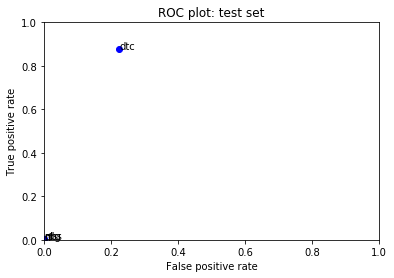

In [29]:
fits = [ols_performance, nbs_performance, dtc_performance, rf_performance, rdg_performance,]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Testing Set on best trained Model

In [30]:
amazonTest = pd.read_csv('/Users/xyche/Documents/Parsons_Grad/ML_Practice/AmazonReview/raw_data_test.csv')
print(amazonTest.shape)

(91000, 13)


### Feature Tansformation

In [31]:
hv = joblib.load('hv.pkl')
X_hv = hv.transform(amazonTest.Text)
#print(X_cv.shape)

In [32]:
transformer = joblib.load('transformer.pkl')
X_tfidf = transformer.transform(X_hv)

In [36]:
corpusSum = amazonTest.Summary.values.astype('U')
hvsum = joblib.load('hvsum.pkl')
X_hvsum = hvsum.transform(corpusSum)
#print(X_cvsum.shape)

In [37]:
transformer_sum = joblib.load('transformer_sum.pkl')
X_tfidf_sum = transformer.transform(X_hvsum)

In [38]:
amazonTest['reviewLen'] = amazonTest['Text'].str.len()
amazonTest['sumLen'] = amazonTest['Summary'].str.len().replace(np.nan,0)


X_length_features = amazonTest[["reviewLen","sumLen"]]

In [39]:
from scipy.sparse import csr_matrix, hstack
X_combined = hstack([X_tfidf,X_tfidf_sum])
X_matrix = csr_matrix(X_combined) # convert to sparse matrix
print(X_matrix.shape)

(91000, 68)


In [40]:
from scipy.sparse import csr_matrix, hstack
X_length_features_csr = csr_matrix(X_length_features)
X_combined = hstack([X_matrix, X_length_features_csr])
X_feature = csr_matrix(X_combined) 
print(X_feature.shape)

(91000, 70)


In [41]:
sc = joblib.load('sc.pkl')
X = sc.transform(X_feature)
print(X.shape)

(91000, 70)


In [42]:
y = amazonTest['helpful'].values
print(type(y))

<class 'numpy.ndarray'>


### Test on the best model dtc

In [44]:
from my_measures import BinaryClassificationPerformance

In [45]:
dtc = joblib.load('dtc.pkl')

dtc_performance = BinaryClassificationPerformance(dtc.predict(X), y, 'dtc')
dtc_performance.compute_measures()
print(dtc_performance.performance_measures)

{'Pos': 6654, 'Neg': 84346, 'TP': 3284, 'TN': 63319, 'FP': 21027, 'FN': 3370, 'Accuracy': 0.7319010989010989, 'Precision': 0.13508288429106166, 'Recall': 0.4935377216711752, 'desc': 'dtc'}


### Graph Performance

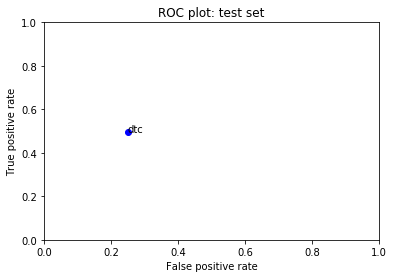

In [46]:
fits = [dtc_performance]

for fit in fits:
    plt.plot(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], 'bo')
    plt.text(fit.performance_measures['FP'] / fit.performance_measures['Neg'], 
             fit.performance_measures['TP'] / fit.performance_measures['Pos'], fit.desc)
plt.axis([0, 1, 0, 1])
plt.title('ROC plot: test set')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

## Samples on the Results

In [53]:
dtc_predictions = dtc.predict(X)

### True Positive - Model says helpful so did the reviewers

In [54]:
#True Positive
import random, time

for i in range(0, len(dtc_predictions)):
    if (dtc_predictions[i] == True):
        if (amazonTest.loc[i, "helpful"] == True):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazonTest.loc[i, "Time"])))
                print(amazonTest.loc[i, "Score"])
                print(amazonTest.loc[i, "HelpfulnessDenominator"])
                print(amazonTest.loc[i, "ProductId"])
                print(amazonTest.loc[i, "Text"])
                print('* * * * * * * * * ')

303
2012-01-15 00:00:00
1
8
B002T0IHJ0
The regular cola flavor has a terrible diet taste.  I hate artificial sweeteners, just can't get used to the chemical taste. I just plain don't like it at all, and poured the rest of the syrup down the drain after using only enough for 1 bottle of soda.  Yep, it's that bad.
* * * * * * * * * 
1776
2011-11-08 00:00:00
5
62
B00416T8Q6
Scientifically speaking, there is only one true cinnamon, which is most commonly called "Ceylon cinnamon," and comes from the plant Cinnamomum zeylanicum. The other type of cinnamon which you find mostly in the grocery stores is called cassia cinnamon. If the label just says cinnamon, it is most probably cassia cinnamon. Why is this important?<br /><br />The term "cassia" never refers to Ceylon cinnamon but rather to other species of cinnamon, including Cinnamomum cassia (alternatively called Cinnamomum aromaticaum) and Cinnamomum burmannii. While most simply referred to as "cassia," you'll often find Cinnamomum aromat

34489
2011-01-29 00:00:00
5
4
B0016687F2
This powder is really good,doesn't have the funky taste a lot of the powders do... Very hard to mix by hand, almost have to use a blender.  It is good with skim milk or water.
* * * * * * * * * 
35075
2007-12-10 00:00:00
5
5
B000XSGMHO
I've tried the Apple, Strawberry, and now the Cherry Pomegranate.  All of them are pretty good. The Cherry Pomegranate doesn't taste that much different than the strawberry.  It might have more of a berry flavor to it.  Compared to a pop tart they're not as flavorful, but they're a step in the healthy direction.  They've got enough sweet to get the job done. Make sure whichever one you buy, that you get the frosted and not the plain.  The plain is too dull without the frosting complimenting it. The only fruit flavor left for me to try now is the blueberry.
* * * * * * * * * 
35268
2010-03-06 00:00:00
5
7
B000WFPJIG
Since I got this for my elderly, frail cat who turns up her nose at a lot of canned food, I guess I'

5
15
B001M050CU
Makes a great cup of sugar free-fat free 25 calorie hot cocoa!  It's not quite as "rich" a product as some of  the gourmet cocoas, but for those of us on restricted diets, it's a really good product. I like the canister because it's convenient and pretty much spill proof.  I took the little single serving packets on vacation and they just don't travel as well as the canister.  PS Add a dash of cinammon or maybe a little almond flavoring if you feel like having a gourmet cocoa!
* * * * * * * * * 
62779
2007-01-11 00:00:00
4
73
B000FL08AQ
I picked up Wholesome Sweeteners Organic Raw Blue Agave recently because it was on sale at a local health food store. I had already made up my mind, after scouting my local stores to no avail, to purchase the Volcanic Nectar brand online but decided to give this a shot because Volcanic Nectar only has one option available (midway in color between Wholesome Sweeteners' lighter option and this one), whereas this looked like a nice alternat

86213
2007-01-16 00:00:00
5
6
B000CQBZQK
This is the first product that I have ever felt strongly enough to write a review on.  This tea has definately gotten some undeserved bad reviews.  It is a Chai Tea!!  It is supposed to be spicey, have a fairly strong flavor, and you are supposed to add sweetner and milk to it.  This VANILLA DECAF CHAI is fantastic!  My kids love it, my guests love it, and I love it!  Everytime I serve it, everyone wants to know where to get it and how I made it.  Even non-tea drinkers get hooked on it.  It is wonderful cold or hot, and has a lighter spice flavor than most Chai teas, but they added a touch of vanilla instead.  This tea really is one that you can enjoy everyday.  It really is worth a try.
* * * * * * * * * 
87600
2011-08-05 00:00:00
5
44
B004P4POZ8
I love this!!! Tastes exactly like peanut butter without the fat and the calories. Finally, I can enjoy one of my favorite snacks guilt-free with all it's health benefits. The PB2 website has the nutri

### True Negative - Model says not helpful so did the reviewers

In [56]:
#True Negative
import random, time

for i in range(0, len(dtc_predictions)):
    if (dtc_predictions[i] == False):
        if (amazonTest.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazonTest.loc[i, "Time"])))
                print(amazonTest.loc[i, "Score"])
                print(amazonTest.loc[i, "HelpfulnessDenominator"])
                print(amazonTest.loc[i, "ProductId"])
                print(amazonTest.loc[i, "Text"])
                print('* * * * * * * * * ')

14
2010-08-31 00:00:00
5
1
B00164V4AE
If ya like salted peanuts, this is it.<br />My crew really like having then around the shop for a quick snack.<br />They stay fresh for a long time easier to carry in you pocket then<br />ones from a jar.
* * * * * * * * * 
22
2012-06-26 00:00:00
1
0
B004H3N2LU
I have been buying numerous K-Cup varieties for the past couple of years and never had a product as bad as this one. Not even close! I grew up with Folgers, Sanka, Nescafe, Hobo Coffee, etc. Ughh!! Grove Square has found a way to make a far worse product and it can be prepared in seconds!! It has a strong bitter motor oil flavor with a slight burned coffee undertone. I have never had a cup of coffee as bad as this one.
* * * * * * * * * 
40
2009-12-19 00:00:00
5
0
B001E95KRE
Fast service the items arrived the next day - Our dog loves them and they make great stocking stuffers for the holidays for our dog and the neighbors.
* * * * * * * * * 
54
2010-02-20 00:00:00
2
2
B000AY9SR2
Is there som

2
B002PKUUK8
I operate an American Steak Restaurant in Japan and use Johnny's Seasoning Salt on all of our Beef Products. I have tried many different Seasonings and this by far is the Best Ever!! Highly Recommended!!
* * * * * * * * * 
4391
2012-10-06 00:00:00
4
0
B0084WJDEK
I love this coffee it is so simple I don't have to add anything to it. This product made my Life a lot easier
* * * * * * * * * 
4443
2012-10-14 00:00:00
4
0
B001EO777A
I like to take a cup of espresso out with me every morning. I was disappointed when the doctor said for me to cut out the caffeine.  This stuff is pretty good and is a good substitute if you are busy, single and take coffee only a cup at a time. Its quite expensive though and lasts only about 6 weeks for the large pack.
* * * * * * * * * 
4533
2012-09-09 00:00:00
1
1
B001BORBM4
I have had my German Shepherd on Canidae (chicken) since she was a puppy and did wonderful. Well, Canidae had a recall last winter & I had to switch her, so I tried Wellness 

1
6
B000FDDET6
I loved this bread WHEN it was a reasonable, economical buy, $9.60 for a carton of six 1 LB boxes.<br />Without any notice of a price change coming or explanation of why the price was being raised to such an extreme, the exact same product is now a whopping $16.01!!! Retail prices on whole wheat flour have gone up, that's no secret. But not almost double... In my book, this price hike is way over the line of reason and that ate 4 of the 5 possible rating Stars. Terrific bread, outrageously priced.
* * * * * * * * * 
8265
2004-12-26 00:00:00
5
0
B00028LTJG
I am a sugar fiend and when I went diet 3 years ago I found this tea! It tastes sweet yet is sugar free, it tastes cold even when it is warm!  I have alwyas liked iced tea and now I drink it by the gallons and say goodbye to sugar sodas!
* * * * * * * * * 
8298
2009-12-01 00:00:00
1
4
B000ETZU2K
my dog would not eat it.  he took one snif and tried to cover it up--don't waste your money.
* * * * * * * * * 
8315
2012-01-2

12012
2011-02-14 00:00:00
4
3
B00451WLYI
Starbucks instant tastes like Starbucks fresh - strong and satisfying. The problem is the expiration date.  I bought this in January and have only until May to drink 50 of them. As I use 2 at a time, that's no problem. I noticed the box was packaged in May 2010, so it's already 6 months old.
* * * * * * * * * 
12068
2008-05-11 00:00:00
5
0
B0000CER9K
This is an excellent coconut tea.  While coconut flavors can often be too sweet or too fake, that's not the case with this tea.  It brews up a nice, dry coconut, in which you can taste both the tea and the coconut flavor.  It's not too sweet to drink in the morning, and I frequently drink it as a morning tea.  For those who like flavored teas, this is a don't-miss.
* * * * * * * * * 
12085
2012-09-26 00:00:00
5
0
B000EDDSE8
Flax seed meal brought my cholesterol down to normal levels.I have no physical proof; However my cholesterol has been up to levels that Doctor's are constantly recommending stain

* * * * * * * * * 
15769
2012-05-24 00:00:00
5
0
B0026KNQSA
Love the taste.  They are low in calories and better than other chips.  Satisfies my sweet cravings.  Give them a try
* * * * * * * * * 
15775
2012-09-01 00:00:00
5
0
B007TGDXMU
My first box just arrived in the mail yesterday.  I love K-cups, but don't love paying for them, and had been using a disposable filter for awhile.  I like that, but it still doesn't seem to work quite as well as the original cups.  These work amazingly well and are so much more affordable.  Not only that, but the coffee itself is great.  I will be recommending this to all my K-cup loving friends!
* * * * * * * * * 
15789
2011-11-11 00:00:00
5
0
B005QRPGQU
Dogs in my neighborhood all enjoy it. This is all around good product for puppy and older adult dogs. I have given it to puppies for now to pull away from chewing shoes. We have some medium puppies 30 lbs and adult 30 lbs dogs. Bull Mastiffs. And they like to chew it. That's good idea.
* * * * * * * 

B005XB3U26
As usual, Starbucks doesn't disappoint...however the price could keep me from buying it again.  At $.50/serving less Green Mountain's "Dark Magic" does the trick on my budget...Cheers!
* * * * * * * * * 
20079
2009-06-05 00:00:00
4
0
B0029ZAOW8
Great product.  It tastes fairly good and does give you a nice burst of energy to do what you need to do on a Wednesday (and Thursday)
* * * * * * * * * 
20155
2009-09-19 00:00:00
1
47
B0026RQTGE
I'll admit, I am reviewing a product I have not used.  The reason is that wheat gluten is about the #1 cause of allergies in dogs.  When wheat gluten is broken down it gets very sticky, so it coats the cilia of the digestive tract.  This can cause irritation, and cause the immune system to actually destroy the lining of the intestines.  This means that your pup might not be able to absorb all the nutrients he is eating.<br /><br />Often allergies show up as 'hot spots' where the dog gets itchy and possibly scratches fur off.  The problem with

* * * * * * * * * 
23175
2008-05-24 00:00:00
2
23
B000HDKZCS
This product may indeed be delicious but the product name is at the very least misleading, at worst deceptive. Anyone with celiac disease or other wheat intolerance needs to know that this product, though free of wheat, is made with multiple grains, including barley flour, and so is unsuitable for their use. Rightfully, the product should be named Multigrain Fig Bars as that is what they are. I don't see why anyone would specifically choose a wheat-free product over one containing wheat unless one is wheat intolerant (and therefore intolerant to all wheat-related grains). What possible legitimate reason could there be then to name this product "Wheat Free"? My rating of the product is based not on the product per se but on the unfortunate and misleading name Barbara's Bakery has chosen to give it. Please note also that a representative of Barbara's Bakery in a private communication to me in response to my objection to the nam

We flavor our iced tea and coffee.  This brand is rich and true, only a little will do ya.  Amazon has the Vanilla at a good price, we get other flavors direct from DaVinci.
* * * * * * * * * 
25371
2009-02-15 00:00:00
5
0
B000GG0BP2
This is probably my favorite Bigelow tea, Chamomile Mint.  I also love Constant Comment by Bigelow with the orange peel and black tea.
* * * * * * * * * 
25401
2011-07-28 00:00:00
4
1
B0006348H2
It grows really fast, but my dog and cat will not eat it. I cut it and put it in with their food.
* * * * * * * * * 
25435
2012-07-31 00:00:00
5
0
B001AYBEPA
These are wonderful nori wraps.  They taste great.  They roll great.  As someone who eats a lot of nori wraps these are a wonderful. Most of my local grocers only carry packages with 10 wraps, I'd often purchase 2 packages a week.  Now, I've saved $ and I don't have to worry about running out.
* * * * * * * * * 
25447
2010-04-16 00:00:00
5
0
B001EQ5MJ8
We love this coffee for the office and home. Great flavor 

B002YR97SS
I love most Bob's Red Mill products and have been buying from them for 10+ years.  However, this is my least favorite of their products.  This stuff is easy to cook with, it's true, but it tastes like rubber, smells bad when it's cooking, and has no flavor until you add your own spices.  I have no idea why I used to cook with this stuff so often other than that I didn't know much about cooking in HS and it looked "high protein" on the label.  I recently read The Whole Soy Story by Kaayla Daniel (Amazon has it), and was amazed to learn that processed soy products like TSP are processed at high temperatures, denaturing the proteins and leaving in loads with antinutrients that damage the thyroid among many other health problems they cause.  Although TSP appears to be almost all protein (like meat or tofu), in reality, you don't absorb much of the protein, anyway.  While I am glad Bob's is using organic soybeans to make their TSP (thereby leaving out the pesticides and genetical

5
4
B001EO5UTM
I grabbed this on a special because it was such a good price for a quality olive oil. When I first tasted it, I was somewhat disappointed, because it had a strong "green" flavor, like the olives hadn't fully ripened. I relegated it to cooking and foods that it would be mixed in with, like hummus. Over time, I have grown to like it more, and now occasionally even use it for drizzling on salads and other foods where the olive oil's flavor is a stand-out part of the dish.<br /><br />I usually drizzle a little EVOO on top of hummus when I serve it along with kalamata olives, feta cheese, tzatziki and tabbouleh. Mmm, one of my favorite meals! I use the Zoe when I make the hummus, then use my favorite <a href="http://www.amazon.com/gp/product/B002BFG56A">'Nunez del Prado' Flor de Aceite Olive Oil Glass by La Tienda</a>, for the drizzle. I have bought it in a 1 Liter tin at my local upscale grocery store, but it is more expensive than the Zoe. I discovered Nunez de Prado when I

2012-07-24 00:00:00
5
1
B007Y59HVM
I read the other reviews and decided to give this brand and style of Keurig cup a try. I, like many, am now a believer. The coffee is excellent and I agree with others who say the taste is enhanced by eliminating the plastic cups other brands use. My wife who is not a "coffee drinker" (per se) even prefers these. Also, the price is relatively reasonable.
* * * * * * * * * 
37517
2008-03-10 00:00:00
5
1
B002N7DSP2
These wafers are awesome, if you like the ones you buy normally in a local grocery store or use to buy you will love these, but be careful, very addictive, just like the others.yummy Great product that is free of gluten.
* * * * * * * * * 
37556
2011-03-13 00:00:00
5
0
B0034EFIYC
LOVE these! Ive only bought them from the health food store! BUT I love kind and they are one of my favorite brands for sure!!! if ur not sure buy one at the market first but you must buy one of each kind they offer lol cause they offer alot :)
* * * * * * * * * 
376

* * * * * * * * * 
41590
2011-03-24 00:00:00
5
0
B001E5DXEU
This is hands down the best Chai that I have ever tasted.  It has a rich creamy vanilla taste that satisfys every time.
* * * * * * * * * 
41594
2011-06-03 00:00:00
4
2
B000KSTY90
I typically drink my coffee with milk and a bit on the sugary side; I had this coffee today straight up black with no milk because I forgot to buy one yesterday and I added a teaspoonful of sugar.  I thought it was going to taste bitter and unfavorable but the aromatic smell tickled my nose and the nutty taste was surprisingly addictive!  I think I found a favorite coffee.
* * * * * * * * * 
41673
2011-08-24 00:00:00
5
2
B0026RQTGE
I was amazed at how well these cleaned my dogs teeth. He is not happy with getting his teeth brushed, especially in the back, the Greenies have assisted with cleaning this hard to reach area. I have read other reviews where people have had trouble with their dogs trying to chew off too much and choking or what-ever - my so

Dr Oz had mentioned how kiwis help the body and have a lot of benifits. I bought these and they are delicious. check them out..
* * * * * * * * * 
46177
2011-06-16 00:00:00
4
1
B004K30HO2
These cups are simple and easy to use the only drawback is the fact that maybe 1/3 of the cups get caught in the unit when you open. However, they are easy to remove once you just close and reopen.
* * * * * * * * * 
46181
2011-05-15 00:00:00
5
0
B001FKC4XA
Luv these bags!  First time using this brand name: easy 2 open, large, strong, easy to insert in doggie bag holder, and lightly scented.  These R my new FAVS!
* * * * * * * * * 
46203
2011-07-23 00:00:00
5
2
B002Y2E7NS
Life before my Bloody Mary Sundays was blah and boring.  Then I discovered Zing Zang  and never want to look back!  It tastes so good when it hits your lips!  JUST AMAZING!  Every sip is tasty and leaves you wanting more. Go for it!  You will not be disappointed!
* * * * * * * * * 
46235
2012-10-15 00:00:00
5
0
B001M1YWBY
I am so gla

1
B001EO7NJ2
I had purchased the Black licorice and thought it to be some of the best I'd ever had, and I do love licorice.  Ordered this only because the Black was not available, but found it tastes more like Grape, of which I am not fond.
* * * * * * * * * 
49859
2011-02-24 00:00:00
5
0
B005PANYEY
I've used Cytomax for the past couple of years now and have found it to be the best rehydration product I've used. Everyone is different but this product has by far worked the best for me at keeping myself going on those long or difficult rides, hikes, cross country ski and snowshoe outings. This also helps to prevent cramping and bonking on those hot humid days when your tend to lose more fluids. I've only had the cool citrus flavor as that is the flavor I've used for years with other hydration products as well, and the flavor though a bit sweet for me is more than acceptable. While cycling I always alternate between a bottle of Cytomax and one of water. For other activities where I carry 

5
0
B000QSN2M4
Arrives always in about 4 days. It is more convenient and cheaper than the store. Recommended!! Great service too. My Dachshund love it!
* * * * * * * * * 
53478
2006-02-22 00:00:00
5
5
B000CBOR60
I bought this tea on a whim while browsing through a Chinese supermarket, thinking that the name would make for good coffeetable conversation.  However, the taste of this product is amazing.  It is easily the best green tea I've ever had, and it's perfect with a little honey or sugar, and a shot of lemon juice or mint.  Excellent tea with a great aftertaste.  You won't be disappointed!
* * * * * * * * * 
53486
2012-02-12 00:00:00
3
0
B004OAZ36I
I had bought this pack because it was my first K-Cup coffee maker. I would have given 4 stars for the variety but I am not a flavored coffee drinker and most of the coffees were of that type.
* * * * * * * * * 
53487
2012-02-25 00:00:00
5
0
B002GJ9JWS
My best friend introduced me to this product some time ago. I really love that I can sp

57167
2011-10-28 00:00:00
1
5
B00451UN84
I was disappointed in the condition of the cans as they arrived almost all with big dents, sometimes more than two on a can. I have heard that it isn't safe to drink from cans that have dents, so I had to research the risk and check out each can for the location of the dents. I contemplated sending them back, but have decided it is most likely safe to drink. Still, this isn't what I had in mind: to drink a beverage that is supposedly good for one's health while being concerned about the remote possibility of botulism! In the future, please package this product properly so it arrives in flawness condition.
* * * * * * * * * 
57192
2010-08-20 00:00:00
5
0
B0012XYVGI
Loved the candy, my spouse used to eat it all the time when he was younger & was so happy we could find it. The shipping was off by a few days but we recieved & everything was good. Tried to contact the seller through email to find out why proudct had not shipped by ship by date and di

* * * * * * * * * 
61921
2011-10-29 00:00:00
2
2
B0017SWABQ
My daughter gets ill from eating anything with flour in it.  She loves gravy and we needed the convinence of a packaged gravy. My daughter says this tastes awful. Would not buy again.
* * * * * * * * * 
61936
2011-10-27 00:00:00
2
2
B004TPKAN4
Now of course I knew that I was getting ginger snaps, so I wanted the taste of ginger to be here, but oh my goodness, for me these cookies are REALLY bitter, way more than the ginger snaps I tried before. I felt as if I burned my mouth a little bit, and after taste stayed with you for some time. And these cookies were really hard too.
* * * * * * * * * 
61941
2010-08-24 00:00:00
4
1
B002HFPW6I
Finally a great tasting nutritious bar, without force feeding you chunks of chocolate, marshmallow, peanut butter, or some other various filler to negate the taste of the raw ingredients. Wonderful product, will buy again.
* * * * * * * * * 
61943
2012-01-11 00:00:00
5
2
B005HUVI40
This is by far t

B000S0XFNQ
This is the best way to store your T-Discs. I have been using it for about a year and it works great. It holds two packages (32 T-discs) easily and rotates freely. Good product.
* * * * * * * * * 
66042
2012-02-29 00:00:00
5
0
B000OSOMDO
Strawberry flavored Pocky is delicous! It's my favorite kind of pocky, and I love it. I would suggest trying it if you like chocolate pocky.
* * * * * * * * * 
66051
2010-02-28 00:00:00
1
4
B0030H1WW0
Tastes more like you put a scoop of powdered chocolate into your coffee to me.  I love a good Mocha...this is not even close!
* * * * * * * * * 
66087
2012-01-23 00:00:00
3
1
B000MQSJB4
I was happy when I go these, they were exactly as advertised. I don't rate them higher because I have since changed my diet-philosophy. I eat Primal now and believe wheat is the devil. I have a strong science background and primal holds up while making every other diet sound like a fairytale.
* * * * * * * * * 
66166
2012-01-27 00:00:00
5
0
B000YUOZU2
I have had

3
B001FVSSG6
I've been eating these, one a day for a year. Yes, I have to ration them. I love them. I've had the dark ones too, but like these a little better. Great coupon deal at Kostco (about $6.50 for 21.2 oz, 50 pieces). The one they're having this year is for assorted, hope I like them all.<br /><br />Edit May 4, 2011. The last two years Kostco's coupon deals on these appeared a month or two before Xmas. They stopped offering a choice between milk and extra dark chocolate varieties and now stock variety packs with extra dark, dark, milk, white, and milk chocolate with peanut butter. I really like them all. I stocked up with a year's supply of these variety bags of 50 the last two years, last time being Nov. 16, 2011. Just like before, I allow myself one a day, but two on Saturdays!
* * * * * * * * * 
70243
2009-05-01 00:00:00
5
1
B00005C2M2
This product was exactly what I was looking for: Freeze-dried Ice cream. I reminded me of grade school and getting it a science centers. I ga

2010-06-22 00:00:00
5
1
B0029XEZB6
My husband I recently ate at an outside cafe in Geneva, IL.  It was late afternoon so we just wanted something light to eat with a glass of wine.  We ordered a cheese plate that include a choice of three cheese.  One of the choices on the menu was a blue cheese listed as "Pointed Reyes Original Farmstead Blue".  It was exceptionally good completly outshining the sharp cheedar and the mild Wisconsin Gouda. So much so that I asked to take a copy of the menu home so I could order the cheese on the internet.  Not as easy as I thought, but I did find it on Amazon and ordered it, after I corrected the spelling to "Point" Reyes rather than "Pointed" Reyes Blue Cheese.<br />  It was delievered in a couple of days intact and as delicious as I remembered. This really is a standout blue cheese especially if you like a tangy sharp blue cheese.  It is creamy but not overpowering and does not have the musky taste that some blue cheeses do. The only downside was the

78432
2011-04-04 00:00:00
5
1
B004VRGS7W
Tasty, I love Vanilla, filling.  I have tried it with the following combinations so far. water , skim milk, cranberries, blueberries, clementine orange. very good and satisfying. I will purchase this again.
* * * * * * * * * 
78435
2011-07-06 00:00:00
2
1
B002MAROZA
I was really excited about this product b/c I put organic milled flax in my kids oatmeal and eggs everyday and was excited about a sproated flax at such a great price, you can barely notice milled flax but this has this really strong odor and taste, even a teaspoon in my kids oatmeal and they wouldn't touch it. Bummer! I gave it 2 stats for the concept.
* * * * * * * * * 
78466
2012-07-06 00:00:00
5
1
B000812K0O
I eat a lot of protein bars and these are really very tasty. Just be careful when ordering in summer - because my box MELTED when delivered a day earlier than expected. Yep, sat out in the sun in 105 degree heat all day... nice. Expensive lesson learned.
* * * * * * * * * 
78

I like this coffee, but compared to the 3 or 4 other blends I have tried from Raven's Brew, this is my least favorite. I was looking for a smoother blend to add a little variety, but this almost boarders on bland. There are hints of a great flavor there, but no matter the grind, amount used or method of making a cup it never tastes better than okay. There is a bit of floral flavor as advertised, but it is not pronounced enough to make this a unique experience.
* * * * * * * * * 
82243
2011-12-29 00:00:00
5
0
B0022M2QI8
I'm a daily iced tea maker and drinker. Bounced around between lots of different teas but settled on plain black tea as my favorite. Found Golden Monkey from a local purveyor which then discontinued it. I loved the clarity and total lack of bitter flavors in the Golden Monkey. The Faerie's golden monkey is just as delicious, and the 12oz package is by far the best deal for this tasty stuff.
* * * * * * * * * 
82312
2011-06-29 00:00:00
5
1
B001P3NU4O
My cat is diabetic, s

B00115P12A
I have been ordering this product for my chihuahua for years. She loves these treats. The only reason I have stuck with these is because they are made in the USA. I just received 2 16 oz packages and read the label (Made in China). I am very disturbed by this finding and will be discarding all of these treats. I will no longer be ordering these in the future and neither will any of my Family and Friends. Amazon needs to look into this. I noticed a huge difference in the looks of the item and feel Amazon has let me down.
* * * * * * * * * 
87093
2012-10-04 00:00:00
5
0
B000A3I3BA
This is such an improvement over trying to stir 'peanuts and salt' peanut butter with any kind of utensil.<br />And it's cute!
* * * * * * * * * 
87108
2012-04-02 00:00:00
5
2
B000N4ZBTI
Don't know WHY this stuff is so horrendously expensive in the grocery stores, for a fraction of the amount you receive from this company.  The price/quality/quantity is a very great value.
* * * * * * * * * 
87161
20

3
1
B0029AXXPI
Yes, these gluten free cookies are absolutely delicious!  There's just no getting around that.  As I was munching my absolutely delicious cookie I had a look-see at the Nutrition Facts printed on the wrapper - that's when I had my second "WOW!".<br />ONE cookie is TWO servings - when was the last time you cut a cookie in half?  So....if you are glutinous enough to eat your entire cookie at one time, you have consumed 340 calories (100 are fat calories)and 40 mg. of cholesterol.  I was astounded to say the least.  As someone with a gluten allergy, I can tell you that there are other really good cookies out there without these kinds of overloads.  Try the Glutino sandwich cookies, for example.
* * * * * * * * * 
90811
2011-01-31 00:00:00
5
0
B0024NKMEU
Great assorment of flavors, but I expected them to come in some sort of Nesco box to hold all of the packets, not a bulk plastic bag with a thermal seal.
* * * * * * * * * 
90838
2012-08-06 00:00:00
5
0
B002ZOPRT8
If you are

### False Positive - Model says helpful but not marked as helpful by reviewers

In [57]:
#False Positive
import random, time

for i in range(0, len(dtc_predictions)):
    if (dtc_predictions[i] == True):
        if (amazonTest.loc[i, "helpful"] == False):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazonTest.loc[i, "Time"])))
                print(amazonTest.loc[i, "Score"])
                print(amazonTest.loc[i, "HelpfulnessDenominator"])
                print(amazonTest.loc[i, "ProductId"])
                print(amazonTest.loc[i, "Text"])
                print('* * * * * * * * * ')

104
2009-05-04 00:00:00
5
0
B000DT7QDM
My dogs love eating Pup-Peroni as their daily treats.  Each individual pouches are great size if you plan to take doggie snacks when you are out at an event or taking them to a dog park or somewhere outside their home.  It was great to have small portions packed in these pouches therefore keeping the snacks fresh.
* * * * * * * * * 
196
2012-10-14 00:00:00
1
0
B000GT3HPK
My Shih Tzu has enjoyed these treats for years.  I used to give them 5 starts.  But then the company started having inventory problems.  Sometimes it would take 2-3 months unless you were willing to pat $250 a box.  Now they've fixed the inventory issues but have totally screwed up the packaging.  Where they used to just place a cardboard strip in the middle of the treat, now they shrink-wrap it in very tough plastic.  You have to fight with it for 5 minutes just to get the darned thing unwrapped.  And they've gone backwards environmentally speaking.  All of the packaging used to 

1
B000SU1LUU
<a href="http://www.amazon.com/gp/product/B000CSKK5A">Orville Redenbacher's Gourmet Microwavable Popcorn, Natural Simply Salted 50% Less Fat, 3-Count Boxes (Pack of 12)</a> I've been ordering Orvlle's popcorn online for a couple of years.  The service is great and so is the popcorn!
* * * * * * * * * 
12172
2011-09-06 00:00:00
5
1
B0030VJ79Q
So very convenient for on the go or at home. My 6 month old can eat this up really quickly with no mess.  Boon makes spoon attachments for these but I have almost found you don't need them.  My girl can literally just suck it out.  Best baby food ever.  I love that it is organic.  Easy clean up....can't go wrong!!! Tastes really good, I will even eat one sometimes if we are out and about.
* * * * * * * * * 
12305
2009-07-08 00:00:00
1
5
B0012XBDH8
I usually love these, but somehow, on arrival, they were actually a little stale.. although the dates were good.. I would not buy them again through Amazon.. We could still eat them, but when

22761
2009-12-28 00:00:00
5
3
B000LKZ91Y
I am not on a gluten/wheat free diet. Instead, I came across this brand while shopping in my grocery store organic food isle. Since then, I have eschewed all other brands of spaghetti for Mrs. Leeper's Wheat/Gluten Free Organic Spaghetti. Here is why:<br /><br />1) I find it more filling then "regular" spaghetti. Typically, pasta leaves me craving more pasta. Not so with Mrs. Leeper's.<br />2) Tastes like the real McCoy.<br />3) Can be frozen after cooking. I boil the entire bag (6 servings) and place what I do not use in individual plastic containers. I defrost as needed.<br /><br />TIP: do not freeze with sauce. If you do, upon defrosting the noodles will break up into tiny little pieces (each less then an inch long). If you freeze the pasta by itself, either defrost it in the fridge, or put in the microwave on the defrost setting. I finish it off by adding the noodles to the sauce in a frying pan. Stir gently and the noodle length will be mos

31827
2012-06-19 00:00:00
5
1
B002PNWU5I
This was my first go at fondant.  It turned out to be really easy with Fondarific and tasted great.  I made black cow spots and a black bow for my son's birthday cake.  Loved it.  I also love that it has a 1 year shelf life.  I was having trouble rolling out the fondant at first, but I realized I was working with fondant that was too warm.  Once I cut down microwave time to 4-5 seconds, it worked much better.
* * * * * * * * * 
31865
2011-01-04 00:00:00
1
1
B002UDSN3G
I am not a picky eater.  I love to try different foods, and enjoy nearly all ethnic foods.  That said, this rub is awful.  It is hard to describe a flavor in words, but the closest I can come are bitter, and rancid.  It is not merely a taste we did not like, it is so bad it is almost impossible to eat.  Save your money, and do not buy this like I did.
* * * * * * * * * 
32081
2011-07-30 00:00:00
3
0
B001J8YRSS
1" x 1.5" tough jerky pieces.  I tear in half.  My shih tzu likes salmon

2012-09-30 00:00:00
4
0
B003YVSIB0
This 25 year balsamic vinegar from Modena Italy is about the best you can come by for the price.  I have tried the $140.00 2 oz bottle and this still beats it.  Although in the past in was less acidic and more of an earthy syrup, sweet, deep in tones and complex palate.  I use this for salads, vegetables, scramble eggs w/parmesian reggiano, and sometimes on the end of my finger.  It makes an excellent Christmas gift and I have not had anyone NOT love it.
* * * * * * * * * 
40241
2012-06-23 00:00:00
5
1
B006QFV68S
My children have been gluten free for 2 years since my oldest was diagnosed with Celiac disease. We now live in a very small town with little to no access to gluten free products and I must order many of my flours & products for baking. New Grains Gluten Free Bakery not only shipped my product quickly but also has excellent customer service which is hard to come by these days. Thank you from the bottom of my heart for helping me keep my famil

49378
2007-07-03 00:00:00
5
0
B000F4H5H2
I normally drink Darjeeling (loose leaf) and this is pretty good for tea in a bag + for those occasions when you must drink decaf (I love a cup of tea in the late evening but can't afford to be kept up by it!)
* * * * * * * * * 
49382
2012-08-03 00:00:00
5
0
B000WMV88O
Its sometimes hard to find good gluten-free treats, let alone wonderful ones.  This particular cookie is one of the wonderful ones and well worth the cost.<br /><br />If you served these and didn't tell anyone, they'd never know these delicious lemon wafer cookies are gluten-free.  They are just the right balance of not being too tart or too sweet and, though I enjoy the chocolate flavor wafer cookies, the lemon ones remain my favorite.  I've taken them along to potluck events and parties and people love them.<br /><br />Eat them as is or garnish a bowl of ice cream with them and you won't be disappointed.  And in a world of disappointment over what items you can't eat if you're g

3
7
B003WFNW32
I ordered and love ideal sweet.  A bag of confectioners sugar was punctured open, and the half of it that came out of the package made everything sticky in the box.  I love cooking with it but am disappointed in the way it was delivered.
* * * * * * * * * 
57604
2012-09-28 00:00:00
3
0
B0012XH7VO
I love yummy earth's candy, especially their chili pops (which have amazing bite), so I figured I would give these a try since I LOVE ginger.<br /><br />I was hoping for a spicy, zesty (like the package says) ginger flavor. Unfortunately, the ginger is not the star of this candy. It's good, just not gingery. I think people who say they don't like ginger would like these, which I think is what yummy earth was going for- since ginger is such an acquired taste.<br /><br />I think they played it way too safe. I will probably buy from the ginger people next time, their candy is very gingery.<br /><br />I still love yummy earth's chili pops and wild peppermint drops!
* * * * * * * * *

67486
2011-11-30 00:00:00
5
1
B000ER3DTE
I really like the glass jars.  As an urban teacher, we use the jars for art classes, but even if we didn't they're more earth friendly than the plastic tubs or bags that other foods come in.  My son LOVES the earth's best carrots.  They're tasty without any of the extras.  I also like the size of the jar.  It's just right to use for two nights of veggie sides.
* * * * * * * * * 
67503
2011-01-09 00:00:00
5
1
B002Y2OWRY
We bought a 3 pack to give to others and I kept one for myself to try.  I'm glad I did because this is great coffee.  It's not as strong as my morning coffee but has a lot of flavor and is perfect for an afternoon or even an early evening coffee.  Surprisingly... we will buy this again and again.  No after taste, no acidic rot gut that you can sometimes get with coffee.  Pretty pleased.<br /><br />If you are on the fence... do what we did... get a 3 pack, give 2 away and keep one for yourself to try.<br /><br />I wish these came i

0
B000F4DKAS
I love green tea, some,  that is. Not all green teas have the clarity and subtle flavor of Twinings. My first action each morning is to have a large mug of green tea with dried cranberries in the bottom of the mug and often I repeat this in the evening. Obviously, I don't want to run out.
* * * * * * * * * 
74048
2012-03-13 00:00:00
5
1
B0018CLZBW
This brand of dog food was recommended to us for our Black Lab, Sadie, as it is very healthy. She absolutely loves it, and her coat is very shiny. We can tell that this is good food, as she is very satisfied. Will definitely order this and possibly other flavors again.
* * * * * * * * * 
74175
2010-12-31 00:00:00
1
6
B002GOYT1O
I highly recommend this product but not from the place I got it<br /><br />I had a sever cases of gastroenteritis after i used the first packet. I disposed of all the remaining packets following that
* * * * * * * * * 
74369
2011-12-28 00:00:00
5
0
B000CR00FQ
These taste great, and when I got them very few

5
1
B000LKZ3OM
Smooth, nutty with hint of honey. It doesn't need refrigerated, but I like to keep it in there, I sometimes eat it with a spoon like ice cream...I really love this.
* * * * * * * * * 
88504
2012-09-23 00:00:00
5
0
B001SB3YSK
I just made the bomb chicken fajitas with this seasoning. They were better then any chicken fajitas I've ever had at any restaurant. GOOD STUFF!!!
* * * * * * * * * 
88524
2010-10-27 00:00:00
5
1
B001PMGB28
Who doesn't like Bit-o-honey?  This is a great value with super speedy service.  Good job!
* * * * * * * * * 
88549
2010-02-17 00:00:00
5
0
B000OC2B9M
These Greenies Pill Pockets make giving pills to dogs a breeze.  Just tear off enough to cover the pill, save some "blanks" as encouraging treats, and your fussy dog will swallow even big pills like his favorite treats.  Especially useful for covering sharp edges of split pills, or masking what might have been bitter tasting to the dog.  No fuss, no clenched jaws, no snapping at you for forcing a pi

### False Negative - Model says not helps but marked as helpful by reviewers

In [58]:
#False Negative
import random, time

for i in range(0, len(dtc_predictions)):
    if (dtc_predictions[i] == False):
        if (amazonTest.loc[i, "helpful"] == True):
            if (random.uniform(0, 1) < 0.05):
                print(i)
                print(time.strftime('%Y-%m-%d %H:%M:%S', time.gmtime(amazonTest.loc[i, "Time"])))
                print(amazonTest.loc[i, "Score"])
                print(amazonTest.loc[i, "HelpfulnessDenominator"])
                print(amazonTest.loc[i, "ProductId"])
                print(amazonTest.loc[i, "Text"])
                print('* * * * * * * * * ')

477
2008-05-17 00:00:00
5
7
B001EQ5L0I
I like trying different teas (primarily non-herbals), and after hearing about Pu-erh I was intriqued.  From what I've read so far, I believe this particular version is not aged like the very high-end, expensive, caked versions are, but it seemed like a good way to get a taste of this tea variety.  I am not disappointed at all.  Though it's not a drastic departure from other teas, it's not quite like any I've had before.  It's very mild and earthy, with a subtle sweetness -- VERY pleasant!<br /><br />Something else that sets it apart from other (non-herbal) teas: It doesn't get bitter after extended steeping!  Furthermore, as I've read elsewhere, just one serving goes a long way.  In fact, I never stop steeping it.  When my cup is almost empty, I just top it off again.  I get at least four flavorful cups with just one of the prewrapped nuggets.<br /><br />This instantly became one of my favorite teas.  I'm delighted I finally discovered it, and jus

16582
2008-06-23 00:00:00
5
6
B004AH6YK4
When I began cooking for myself about 6 years ago, I tried five or six different recipes for chicken vindaloo, from Madhur Jaffrey's classic recipe to actor Anthony Hopkins' "healthful" one (which I found on some entertainment Web site).<br /><br />Most were good, with Jaffrey's being the best of the bunch, Hopkins' the worst (Hannibal's take on vindaloo was surprisingly bland). None of the recipes were nearly as good, however, as the spiced-just-right vindaloo I used to order at least once a week from Baluchi's when I lived in New York City.<br /><br />During my recipe experimentation, I visited a local Asian grocery store and asked the clerk for some advice. He recommended trying Patak's paste. I was dubious, but I did. It was absolutely great. And the bonus: The Patak's recipe is much easier to fix than the various recipes I had been collecting.<br /><br />I've cooked with this paste so often now, I've learned to make a few alterations to the

30480
2007-10-30 00:00:00
5
8
B000E65OJW
I love black tea, but no longer drink gallons of it day and night, because of the caffeine.  This tea is the only caffeine-free tea that can come anywhere close to passing for real tea.  It's not as wonderful as real tea, but compared to the herbal drek that most people consume, it's heaven.  It's an herbal formulation, but it contains "tea essence" as an ingredient.  I let it steep a long time.  Sometimes I put in a splash of milk or cream.  I take the bags with me on trips.  It's not so easy to find, and I've always snatched up all the boxes I could get my hands on (when I could find it in Whole Foods, for example), so buying it in bulk on Amazon is great!
* * * * * * * * * 
30897
2010-01-03 00:00:00
3
7
B000SAPX8G
I'll admit it, I was attracted by the price and the lack of negative reviews.  I really wanted to like this product.  I've been drinking sencha for years and drink a lot of it.  This particular tea is certainly drinkable, but it lac

46560
2010-12-04 00:00:00
4
5
B00153C4B4
overall synapsis:<br /><br />The Pacific Natural Foods Organic Free Range Chix Broth is a very healthy alternative to most of the broth sold on the market(s) and it has a neutral flavor to let one either spice it up and keep it down.<br /><br />It tastes decent, not especially flavorful when compare to some other brands.<br /><br />It has lower sodium and than a lot of broths out there but the sea salt gives it a more "salty" taste.<br /><br />It doesn't use a lot of articificial ingredients other stock/broths put in theirs. Overall, a decent stock for general use.<br /><br />~~~~~~~~~~~~~~~~~~~~~~~<br />(detailed review for those wanting more indepth review)<br /><br />*note* most stores sell broths (and not stock). So in my review, I often will use "broth" when comparing the stock to other broths(the ones in the supermarkets). Hope this helps :-)<br /><br />1) Taste:<br /><br />it is neutral, but we like to add our own ingredients to our own s

* * * * * * * * * 
67380
2009-02-07 00:00:00
5
13
B001GVIUVS
My cat has had a delicate stomach. I have tried many different foods and tricks. Since I started feeding him this, he has had no throwing up. I have to feed him more than I did. He doesn't seem to get satisfied as quickly. His sister who has no stomach problems needs larger portions too. they both have no complaints about the taste. This stuff is expensive. It is worth it to not have him throw up all the time.
* * * * * * * * * 
67594
2012-01-05 00:00:00
5
7
B003Z7VYXW
I have been making bread machine bread for about four years now.  Until recently I'd been using the little brown jars of Fleischmann's or Red Star bread machine yeast because I thought that was all there was.  Then my local markets stopped carrying that variety.  The little packets are way too expensive and I had a sad experience with cratered loaves and uneven texture when one cookbook assured me that active dry yeast would work fine with bread machines.<br />

83190
2012-02-14 00:00:00
4
4
B001LO1A0S
Our first taste of Super Veggie made my wife and I reminiscent of a Bloody Mary. So much so, that we squeezed some lime in along with black pepper, a dash of celery seed and tabasco. No alcohol though, so I guess it would be considered a Virgin Mary! It was delicious and now we have one each evening.<br /><br />I have been drinking V8 Lower Sodium for quite a few years and have recently switched to Super Veggie for the additional health qualities. When compared to V8, it seems to be superior in every aspect. Super Veggie has a lot less sodium, higher fiber, less tomato and more of the other juices. I feel that it is more comparable to an actual serving of vegetables than V8. I'm very happy with this product.<br /><br />I gave Super Veggie 4 stars because it is 3 times as expensive as V8. I have calculated that I pay about 15 cents an ounce for Super Veggie, and a little less than 5 cents an ounce for V8. Don't get me wrong, Super Veggie is worth